In [1]:
from collections import deque

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import nltk
from torch.utils.data import Dataset
import pickle

from utils.utils import *
from utils.label_decoding import *
from utils.HierarchicalLoss import *



In [2]:
import torch
import numpy as np
import json
from tqdm import tqdm
import subprocess

def evaluate_models(models, dataloader, pred_file_path, gold_file_path, 
                    evaluator_script_path, id2leaf_label, device, validation=False, format=None,
                    threshold=0.3):
    # Ensure all models are in evaluation mode
    for model in models:
        model.eval()
    
    predictions = []
    total_loss = 0 if validation else None
    HL = HierarchicalLoss(id2label=id2label_1, hierarchical_labels=hierarchy_1, persuasion_techniques=persuasion_techniques_1, device=device)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            ids = batch['id'].detach().numpy().tolist() if not isinstance(batch['id'], list) else batch['id']
            # mBERT_embeddings = batch['text_features_1'].to(device)
            # RoBERTa_embeddings = batch['text_features_2'].to(device)
            
            # Collect predictions from all models
            batch_predictions = []
            
            
            for idx in range(len(models)):
                try:
                    model = models[idx]
                    embeddings = batch[f'text_features_{idx}'].to(device)
                    batch_predictions.append(model(embeddings))
                except:
                    model = models[idx]
                    embeddings1 = batch[f'text_features_{1}']
                    embeddings2 = batch[f'text_features_{idx}'].to(device)
                    batch_predictions.append(model(embeddings1, embeddings2))
                    
                
            # batch_predictions.append(model1(mBERT_embeddings))
            # batch_predictions.append(model2(mBERT_embeddings, RoBERTa_embeddings))
            
            # Soft voting: average the predictions across models
            
            avg_preds = [torch.stack([model_preds[j] for model_preds in batch_predictions]).mean(0) for j in range(5)]
            
            pred_1, pred_2, pred_3, pred_4, pred_5 = avg_preds
            
            if validation:
                y_1, y_2, y_3 = batch['level_1_target'], batch['level_2_target'], batch['level_3_target']
                y_4, y_5 = batch['level_4_target'], batch['level_5_target']
                y_1, y_2, y_3, y_4, y_5 = y_1.to(device), y_2.to(device), y_3.to(device), y_4.to(device), y_5.to(device)
                
                dloss = HL.calculate_dloss([pred_1, pred_2, pred_3, pred_4, pred_5], [y_1, y_2, y_3, y_4, y_5])
                lloss = HL.calculate_lloss([pred_1, pred_2, pred_3, pred_4, pred_5], [y_1, y_2, y_3, y_4, y_5])
                total_loss += (dloss + lloss).item()

            # Threshold predictions for classification
            pred_3 = (pred_3 > threshold).int().cpu().numpy()
            pred_4 = (pred_4 > threshold).int().cpu().numpy()
            pred_5 = (pred_5 > threshold).int().cpu().numpy()
            # print(ids)
            predictions += get_labels(id2leaf_label, ids, pred_3, pred_4, pred_5, format)

    # Writing JSON data
    with open(pred_file_path, 'w') as f:
        json.dump(predictions, f, indent=4)
    
    if gold_file_path is not None:
        command = ["python3", evaluator_script_path, "--gold_file_path", gold_file_path, "--pred_file_path", pred_file_path]
        result = subprocess.run(command, capture_output=True, text=True)
        if result.returncode == 0:
            print("Output:\n", result.stdout)
        else:
            print("Error:\n", result.stderr)
    
    if validation:
        return total_loss / len(dataloader)


### mBERT

In [3]:
from modules.nn.mBERT import mBERT

mBERT_model = mBERT()
mBERT_model.load_state_dict(torch.load('./models/subtask1a/mBERT-200/ancient-sweep-5.pth'))

<All keys matched successfully>

### XLM-RoBERTa

In [20]:
from modules.nn.XLMRoBERTa import XLMRoBERTa

XLMRoBERTa_model = XLMRoBERTa()
XLMRoBERTa_model.load_state_dict(torch.load('./models/subtask1a/XLM-RoBERTa/radiant-sweep-4.pth'))

<All keys matched successfully>

### XLNet

In [21]:
from modules.nn.XLNet import XLNet

xlnet_model = XLNet()
xlnet_model.load_state_dict(torch.load("./models/subtask1a/XLNet-200/fanciful-sweep-1.pth"))

<All keys matched successfully>

### openAi small 

In [22]:
from modules.nn.OpenAiSmall import OpenAiSmall

openai_small = OpenAiSmall()
# openai_small.load_state_dict(torch.load('./models/subtask1a/text-embedding-3-small/openai_small-3.pth'))
# openai_small.load_state_dict(torch.load("./models/subtask1a/openAI-Small/chocolate-sweep-8.pth"))
openai_small.load_state_dict(torch.load("./models/subtask1a/openAI-Small/crisp-sweep-2.pth"))

<All keys matched successfully>

### openai large

In [23]:
from modules.nn.OpenAiLarge import OpenAiLarge

    
openai_large = OpenAiLarge()
openai_large.load_state_dict(torch.load('./models/subtask1a/text-embedding-3-large/openai_large.pth'))
# openai_large.load_state_dict(torch.load('./models/subtask1a/openAI-Large/trim-sweep-4.pth'))

<All keys matched successfully>

### openai large NER

In [24]:
from modules.nn.OpenAiLarge import OpenAiLargeNER

openai_ner_model = OpenAiLargeNER()
openai_ner_model.load_state_dict(torch.load('./models/subtask1a/openAI-Large-NER/misty-sweep-4.pth'))

<All keys matched successfully>

In [25]:
from modules.nn.OpenAiLarge import OpenAiLargeMultiLingualNER

openai_mner = OpenAiLargeMultiLingualNER()
openai_mner.load_state_dict(torch.load('./models/subtask1a/openAI-Large-m-NER/gallant-sweep-7.pth'))

<All keys matched successfully>

In [10]:
class TestDataSet(Dataset):
    def __init__(self, df, features_files):
        super(TestDataSet, self).__init__()
        self.data_df = df
        self.features_files = features_files
        self.features_dict = []
        
        for features_file in features_files:
            with open(features_file, 'rb') as f:
                self.features_dict.append(pickle.load(f))
        
        
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        id = self.data_df.iloc[idx]['id']
        text = self.data_df.iloc[idx]['cleaned_text']
        
        features = {f'text_features_{idx}': self.features_dict[idx][id] for idx in range(len(self.features_files))}
        
        features['id'] = id
        features['text'] = text
        
        return features

In [14]:
from torch.utils.data import DataLoader
evaluator_script = './scorer-baseline/subtask_1_2a.py'

### text-embeddings-small + text-embeddings-large + text-embeddings-large-multilingual-ner

In [158]:
bulgarian_pred_file_path = './Predictions/bulgarian_predictions_subtask1.txt'
bulgarian_gold_file_path = './test_labels_ar_bg_md_version2/test_subtask1_bg.json'
evaluator_script = './scorer-baseline/subtask_1_2a.py'

bg_test_data = process_test_json(bulgarian_gold_file_path)


features_files = ['TextFeatures/subtask1a/text-embedding-3-small/bg_test_text_features.pkl',
                  'TextFeatures/subtask1a/text-embedding-3-large/bg_test_text_features.pkl',
                  'TextFeatures/subtask1a/multilingual-ner/bg_test_text_features.pkl', 
                  'TextFeatures/subtask1a/mBERT/bg_test_text_features.pkl'
                  ]

bg_test_dataset = TestDataSet(bg_test_data, features_files)
bg_test_dataloader = DataLoader(bg_test_dataset, batch_size=64, shuffle=True)

evaluate_models([openai_small, openai_large, openai_mner], bg_test_dataloader,
                bulgarian_pred_file_path, bulgarian_gold_file_path,
               evaluator_script, id2leaf_label, validation=False, device=torch.device('cpu'), threshold=0.3)

100%|██████████| 7/7 [00:00<00:00, 35.18it/s]


Output:
 f1_h=0.45951	prec_h=0.49609	rec_h=0.42796


In [159]:
macedonian_pred_file_path = './Predictions/macedonian_predictions_subtask1.txt'
macedonian_gold_file_path = './test_labels_ar_bg_md_version2/test_subtask1_md.json'

md_test_data = process_test_json(macedonian_gold_file_path)

features_files = ['TextFeatures/subtask1a/text-embedding-3-small/md_test_text_features.pkl',
                  'TextFeatures/subtask1a/text-embedding-3-large/md_test_text_features.pkl',
                  'TextFeatures/subtask1a/multilingual-ner/md_test_text_features.pkl',
                  'TextFeatures/subtask1a/mBERT/md_test_text_features.pkl']

md_test_dataset = TestDataSet(md_test_data, features_files)
md_test_dataloader = DataLoader(md_test_dataset, batch_size=64, shuffle=True)

evaluate_models([openai_small, openai_large, openai_mner], md_test_dataloader,
                macedonian_pred_file_path, macedonian_gold_file_path,
               evaluator_script, id2leaf_label, validation=False, device=torch.device('cpu'), threshold=0.3)

100%|██████████| 5/5 [00:00<00:00, 55.34it/s]


Output:
 f1_h=0.42587	prec_h=0.59341	rec_h=0.33210


In [160]:
arabian_pred_file_path = './Predictions/arabian_predictions_subtask1.txt'
arabian_gold_file_path = './test_labels_ar_bg_md_version2/test_subtask1_ar.json'

ar_test_data = process_test_json(arabian_gold_file_path)

features_files = [ 'TextFeatures/subtask1a/text-embedding-3-small/ar_test_text_features.pkl',
                  'TextFeatures/subtask1a/text-embedding-3-large/ar_test_text_features.pkl',
                  'TextFeatures/subtask1a/multilingual-ner/ar_test_text_features.pkl',
                  'TextFeatures/subtask1a/mBERT/ar_test_text_features.pkl']

ar_test_dataset = TestDataSet(ar_test_data, features_files)
ar_test_dataloader = DataLoader(ar_test_dataset, batch_size=64, shuffle=True)

evaluate_models([openai_small, openai_large, openai_mner], ar_test_dataloader, arabian_pred_file_path,
                arabian_gold_file_path, evaluator_script, 
               id2leaf_label, format=5, validation=False, device=torch.device('cpu'), threshold=0.3)

100%|██████████| 2/2 [00:00<00:00, 49.64it/s]


Output:
 f1_h=0.44079	prec_h=0.41486	rec_h=0.47018


In [162]:
en_pred_file_path = './Predictions/en_predictions_subtask1.txt'


en_test_data = process_test_json('./test_data/english/en_subtask1_test_unlabeled.json')

features_files = ['./TextFeatures/subtask1a/text-embedding-3-small/en_test_text_features.pkl',
                  './TextFeatures/subtask1a/text-embedding-3-large/en_test_text_features.pkl', 
                  './TextFeatures/subtask1a/multilingual-ner/en_test_text_features.pkl', 
                  ]

en_test_dataset = TestDataSet(en_test_data, features_files)

en_test_dataloader = DataLoader(en_test_dataset, batch_size=128)

evaluate_models([openai_small, openai_large, openai_mner],
                en_test_dataloader, 
                en_pred_file_path, None, evaluator_script, id2leaf_label, validation=False,
                device=torch.device('cpu'),
                threshold=0.3)

100%|██████████| 12/12 [00:00<00:00, 33.22it/s]


0.64982	0.66939	0.63137

### text-embeddings-small + text-embeddings-large + text-embeddings-large-multilingual-ner + mBERT

In [120]:
bulgarian_pred_file_path = './Predictions/bulgarian_predictions_subtask1.txt'
bulgarian_gold_file_path = './test_labels_ar_bg_md_version2/test_subtask1_bg.json'
evaluator_script = './scorer-baseline/subtask_1_2a.py'

bg_test_data = process_test_json(bulgarian_gold_file_path)


features_files = ['TextFeatures/subtask1a/text-embedding-3-small/bg_test_text_features.pkl',
                  'TextFeatures/subtask1a/text-embedding-3-large/bg_test_text_features.pkl',
                  'TextFeatures/subtask1a/multilingual-ner/bg_test_text_features.pkl', 
                  'TextFeatures/subtask1a/mBERT/bg_test_text_features.pkl'
                  ]

bg_test_dataset = TestDataSet(bg_test_data, features_files)
bg_test_dataloader = DataLoader(bg_test_dataset, batch_size=64, shuffle=True)

evaluate_models([openai_small, openai_large, openai_mner, mBERT_model], bg_test_dataloader,
                bulgarian_pred_file_path, bulgarian_gold_file_path,
               evaluator_script, id2leaf_label, validation=False, device=torch.device('cpu'), threshold=0.3)

100%|██████████| 7/7 [00:00<00:00, 61.69it/s]


Output:
 f1_h=0.48411	prec_h=0.50809	rec_h=0.46229


In [134]:
macedonian_pred_file_path = './Predictions/macedonian_predictions_subtask1.txt'
macedonian_gold_file_path = './test_labels_ar_bg_md_version2/test_subtask1_md.json'

md_test_data = process_test_json(macedonian_gold_file_path)

features_files = ['TextFeatures/subtask1a/text-embedding-3-small/md_test_text_features.pkl',
                  'TextFeatures/subtask1a/text-embedding-3-large/md_test_text_features.pkl',
                  'TextFeatures/subtask1a/multilingual-ner/md_test_text_features.pkl',
                  'TextFeatures/subtask1a/mBERT/md_test_text_features.pkl']

md_test_dataset = TestDataSet(md_test_data, features_files)
md_test_dataloader = DataLoader(md_test_dataset, batch_size=64, shuffle=True)

evaluate_models([openai_small, openai_large, openai_mner, mBERT_model], md_test_dataloader,
                macedonian_pred_file_path, macedonian_gold_file_path,
               evaluator_script, id2leaf_label, validation=False, device=torch.device('cpu'), threshold=0.3)

100%|██████████| 5/5 [00:00<00:00, 44.22it/s]


Output:
 f1_h=0.46615	prec_h=0.62218	rec_h=0.37269


In [144]:
arabian_pred_file_path = './Predictions/arabian_predictions_subtask1.txt'
arabian_gold_file_path = './test_labels_ar_bg_md_version2/test_subtask1_ar.json'

ar_test_data = process_test_json(arabian_gold_file_path)

features_files = [ 'TextFeatures/subtask1a/text-embedding-3-small/ar_test_text_features.pkl',
                  'TextFeatures/subtask1a/text-embedding-3-large/ar_test_text_features.pkl',
                  'TextFeatures/subtask1a/multilingual-ner/ar_test_text_features.pkl',
                  'TextFeatures/subtask1a/mBERT/ar_test_text_features.pkl']

ar_test_dataset = TestDataSet(ar_test_data, features_files)
ar_test_dataloader = DataLoader(ar_test_dataset, batch_size=64, shuffle=True)

evaluate_models([openai_small, openai_large, openai_mner, mBERT_model], ar_test_dataloader, arabian_pred_file_path,
                arabian_gold_file_path, evaluator_script, 
               id2leaf_label, format=5, validation=False, device=torch.device('cpu'), threshold=0.3)

100%|██████████| 2/2 [00:00<00:00, 51.00it/s]


Output:
 f1_h=0.44478	prec_h=0.39510	rec_h=0.50877


In [163]:
en_pred_file_path = './Predictions/en_predictions_subtask1.txt'


en_test_data = process_test_json('./test_data/english/en_subtask1_test_unlabeled.json')

features_files = ['./TextFeatures/subtask1a/text-embedding-3-small/en_test_text_features.pkl',
                  './TextFeatures/subtask1a/text-embedding-3-large/en_test_text_features.pkl', 
                  # './TextFeatures/subtask1a/BERT-NER/en_test_text_features.pkl', 
                  './TextFeatures/subtask1a/multilingual-ner/en_test_text_features.pkl', 
                  './TextFeatures/subtask1a/mBERT/en_test_text_features.pkl']

en_test_dataset = TestDataSet(en_test_data, features_files)

en_test_dataloader = DataLoader(en_test_dataset, batch_size=128)

evaluate_models([openai_small, openai_large, openai_mner, mBERT_model],
                en_test_dataloader, 
                en_pred_file_path, None, evaluator_script, id2leaf_label, validation=False,
                device=torch.device('cpu'),
                threshold=0.3)

100%|██████████| 12/12 [00:00<00:00, 26.42it/s]


0.65706	0.68876	0.62815

### text-embeddings-small + text-embeddings-large + text-embeddings-large-multilingual-ner + mBERT + BERT-ner

Only for English

In [28]:
en_pred_file_path = './Predictions/en_predictions_subtask1.txt'


en_test_data = process_test_json('./test_data/english/en_subtask1_test_unlabeled.json')

features_files = ['./TextFeatures/subtask1a/text-embedding-3-small/en_test_text_features.pkl',
                  './TextFeatures/subtask1a/text-embedding-3-large/en_test_text_features.pkl', 
                  './TextFeatures/subtask1a/BERT-NER/en_test_text_features.pkl', 
                  './TextFeatures/subtask1a/multilingual-ner/en_test_text_features.pkl', 
                  './TextFeatures/subtask1a/mBERT/en_test_text_features.pkl']

en_test_dataset = TestDataSet(en_test_data, features_files)

en_test_dataloader = DataLoader(en_test_dataset, batch_size=128)

evaluate_models([openai_small, openai_large, openai_ner_model, openai_mner, mBERT_model],
                en_test_dataloader, 
                en_pred_file_path, None, evaluator_script, id2leaf_label, validation=False,
                device=torch.device('cpu'),
                threshold=0.3)

100%|██████████| 12/12 [00:00<00:00, 20.40it/s]


0.66143	0.69620	0.62997

In [31]:
en_test_dataset[0].keys()

for i in range(5):
    print(en_test_dataset[0][f'text_features_{i}'].shape)

(1536,)
(3072,)
(1024,)
(768,)
(768,)


In [41]:
en_dev_pred_file_path = './Predictions/ensemble_en_dev_predictions_subtask1.txt'
en_dev_gold_file_path = './dev_gold_labels/dev_subtask1_en.json'


en_dev_test_data = process_test_json(en_dev_gold_file_path)

features_files = ['./TextFeatures/subtask1a/text-embedding-3-small/en_dev_text_features.pkl',
                  './TextFeatures/subtask1a/text-embedding-3-large/en_dev_text_features.pkl', 
                  './TextFeatures/subtask1a/BERT-NER/en_dev_text_features.pkl', 
                  './TextFeatures/subtask1a/multilingual-ner/en_dev_text_features.pkl', 
                  './TextFeatures/subtask1a/mBERT/en_dev_text_features.pkl']

en_dev_test_dataset = TestDataSet(en_dev_test_data, features_files)

en_dev_test_dataloader = DataLoader(en_dev_test_dataset, batch_size=128)

evaluate_models([openai_small, openai_large, openai_ner_model, openai_mner, mBERT_model],
                en_dev_test_dataloader, 
                en_dev_pred_file_path, en_dev_gold_file_path, evaluator_script, id2leaf_label, validation=False,
                device=torch.device('cpu'),
                threshold=0.3)

100%|██████████| 8/8 [00:00<00:00, 21.03it/s]


Output:
 f1_h=0.63375	prec_h=0.67708	rec_h=0.59563


In [35]:
en_dev_test_dataset[0].keys()

for i in range(5):
    print(en_dev_test_dataset[0][f'text_features_{i}'].shape)

(1536,)
(3072,)
(1024,)
(768,)
(768,)


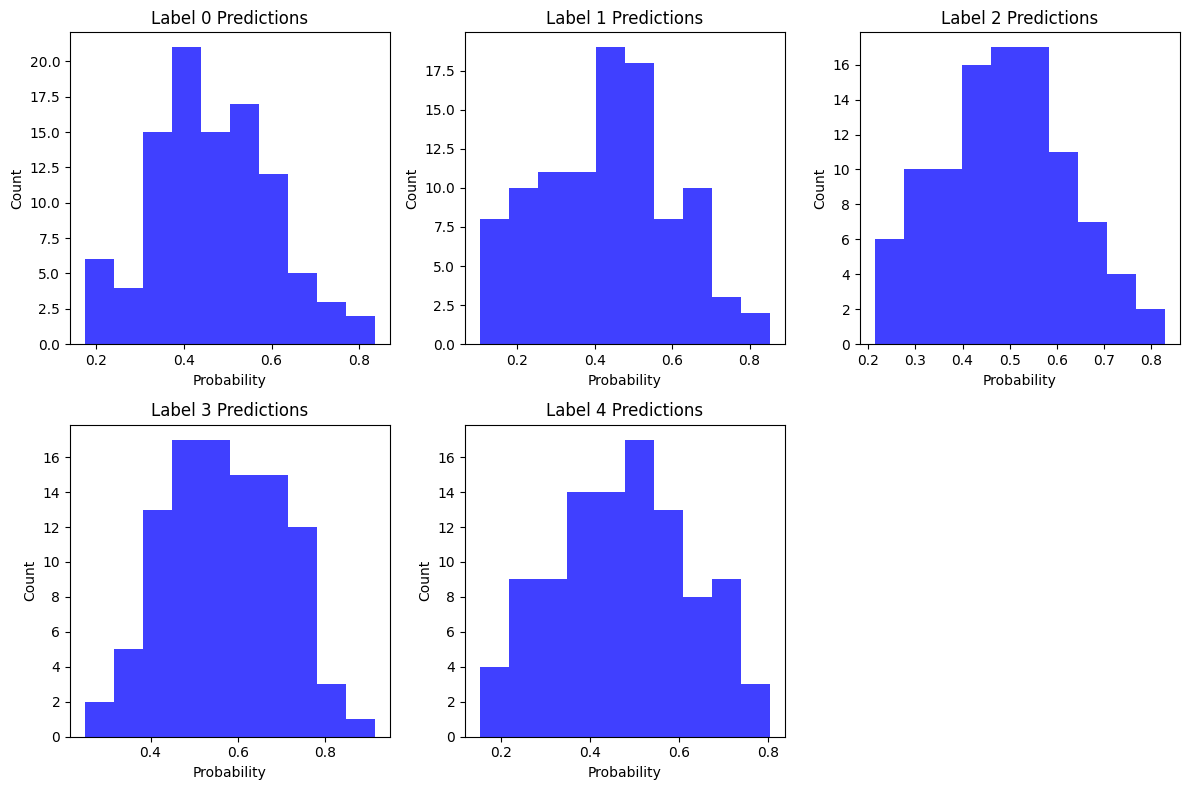

In [64]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define a simple neural network model for multi-label classification
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(10, 5)  # Example: input features=10, output features=5 (5 labels)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Sigmoid activation for multi-label classification

# Initialize the model
model = SimpleNN()

# Generate a batch of dummy data
batch_size = 100
dummy_data = torch.randn(batch_size, 10)

# Get predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(dummy_data)

# Print the predictions
# print("Predictions:")
# print(predictions)

# Plot the distribution of predictions for each label
plt.figure(figsize=(12, 8))
for i in range(predictions.shape[1]):  # Loop over each label
    plt.subplot(2, 3, i+1)  # Create a subplot for each label
    plt.hist(predictions[:, i].numpy(), bins=10, alpha=0.75, color='blue')
    plt.title(f'Label {i} Predictions')
    plt.xlabel('Probability')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()
